In [1]:
import sys, math, os
import numpy as np
import pymbar
import matplotlib.pyplot as plt
from pymbar import timeseries
from pymbar.utils import kn_to_n, logsumexp

In [2]:
# constants
R = 8.31446261815324 / 1000.0 # gas constant, kJ K-1 mol-1
T = float(300)
cal2j = float(4.1841)
beta = 1.0 / (R * T)

#parameters setup
cv_file = np.loadtxt('../dist.dat')
dist_T = np.loadtxt('../dist/dist.dat.1', dtype='str')[180000:900000:45]

min1 = cv_file[0,0]-0.5
max1 = cv_file[-1,0]+1
nrep = int(np.size(cv_file[:,0]))
nsample = int(np.size(dist_T[:,0]))
T_k = np.ones(nrep, float) * T
fe_max = 10000000.0
beta_k = 1.0/(R * T_k)

delta = 0.25
nbins = int( (max1-min1) / delta )
cutoff = float(10)

In [3]:
N_k = np.zeros([nrep], np.int64)
K_k = np.zeros([nrep], np.float64)
dist0_k = np.zeros([nrep], np.float64)
dist_kn = np.zeros([nrep, nsample], np.float64)
u_kn = np.zeros([nrep, nsample], np.float64)
g_k = np.zeros([nrep], np.float64)

In [4]:
# Read in umbrella spring constants and centers.
filename = '../dist.dat'
lines = np.loadtxt(filename)
for k in range(nrep):
    line = lines[k]
    dist0_k[k] = float(line[0])
    K_k[k] = 2 * float(line[1]) * cal2j
    if len(line) > 2:
        T_k[k] = float(line[2])

In [5]:
for k in range(nrep):
    j = k+1
    filename = '../dist/dist.dat.%d' % j
    print("Reading %s..." % filename)
    temp = np.float64(np.loadtxt(filename, dtype='str')[:,7][180000:900000:45])
    lines = np.column_stack( [ np.where(temp.T)[0], temp.T ] )

    n=0
    for line in lines:
        a = float(line[1])
        dist_kn[k, n] = a
        n += 1
    N_k[k] = n

    #g_k[k] = timeseries.statisticalInefficiency(dist_kn[k, 0:N_k[k]])
    #indices = timeseries.subsampleCorrelatedData(dist_kn[k, 0:N_k[k]], g=g_k[k])

    #N_k[k] = len(indices)
    #u_kn[k, 0:N_k[k]] = u_kn[k, indices]
    #dist_kn[k, 0:N_k[k]] = dist_kn[k, indices]

cv_dist = np.hstack( [ (np.where(dist_kn[n,:])[0]+1, dist_kn[n,:]) for n in range(nrep) ] ).T

Reading ../dist/dist.dat.1...
Reading ../dist/dist.dat.2...
Reading ../dist/dist.dat.3...
Reading ../dist/dist.dat.4...
Reading ../dist/dist.dat.5...
Reading ../dist/dist.dat.6...
Reading ../dist/dist.dat.7...
Reading ../dist/dist.dat.8...
Reading ../dist/dist.dat.9...
Reading ../dist/dist.dat.10...
Reading ../dist/dist.dat.11...
Reading ../dist/dist.dat.12...
Reading ../dist/dist.dat.13...
Reading ../dist/dist.dat.14...
Reading ../dist/dist.dat.15...
Reading ../dist/dist.dat.16...
Reading ../dist/dist.dat.17...
Reading ../dist/dist.dat.18...
Reading ../dist/dist.dat.19...
Reading ../dist/dist.dat.20...
Reading ../dist/dist.dat.21...
Reading ../dist/dist.dat.22...
Reading ../dist/dist.dat.23...
Reading ../dist/dist.dat.24...
Reading ../dist/dist.dat.25...
Reading ../dist/dist.dat.26...
Reading ../dist/dist.dat.27...
Reading ../dist/dist.dat.28...


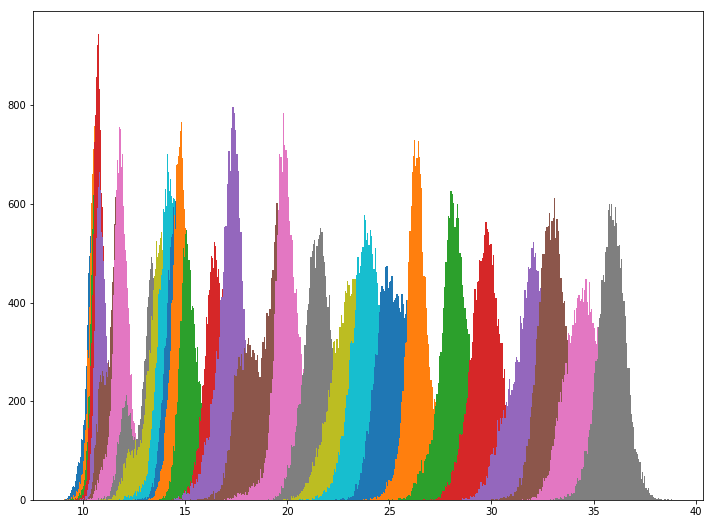

In [24]:
plt.figure(figsize=(12,9))
for i in range(nrep):
    plt.hist(dist_kn[i], bins=100)
plt.show()

In [6]:
N_max = np.max(N_k)
u_kln = np.zeros([nrep, nrep, N_max], np.float64)
u_kn -= u_kn.min()

In [7]:
print("Binning data...")

bin_center_i = np.zeros([nbins], np.float64)
bin_kn = np.zeros([nrep, nsample], np.int64)

for i in range(nbins):
    bin_center_i[i] = min1 + delta/2 + delta * i

for k in range(nrep):
    for n in range(N_k[k]):
        bin_kn[k, n] = int((dist_kn[k, n] - min1) / delta)

Binning data...


In [8]:
print("Evaluating reduced potential energies...")

for k in range(nrep):
    for n in range(N_k[k]):
        d_dist = dist_kn[k, n] - dist0_k
        u_kln[k,:,n] = u_kn[k,n] + beta_k[k] * (0.5 * K_k) * d_dist**2

Evaluating reduced potential energies...


In [9]:
print("Running MBAR...")
mbar = pymbar.MBAR(u_kln, N_k, maximum_iterations=10000, initialize='zeros', verbose = True)

Running MBAR...
K (total states) = 28, total samples = 448000
N_k = 
[16000 16000 16000 16000 16000 16000 16000 16000 16000 16000 16000 16000
 16000 16000 16000 16000 16000 16000 16000 16000 16000 16000 16000 16000
 16000 16000 16000 16000]
There are 28 states with samples.
Initializing free energies to zero.
Initial dimensionless free energies with method zeros
f_k = 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Determining dimensionless free energies by Newton-Raphson / self-consistent iteration.
self consistent iteration gradient norm is  7.071e+07, Newton-Raphson gradient norm is 3.4201e+08
Choosing self-consistent iteration on iteration 0
self consistent iteration gradient norm is  2.634e+07, Newton-Raphson gradient norm is 8.6904e+06
Choosing self-consistent iteration for lower gradient on iteration 1
self consistent iteration gradient norm is 1.6301e+07, Newton-Raphson gradient norm is 6.1656e+06
Newton-Raphson used on iteration 2
self c

In [10]:
result = mbar.computePMF(u_kn, bin_kn, nbins)
f_i = result[0]
df_i = result[1]

In [11]:
print("PMF (in units of kT)")
print("%8s %8s %8s" % ('bin', 'f', 'df'))
for i in range(nbins):
    #print("%8.1f %8.3f %8.3f" % (bin_center_i[i], f_i[i] * R * T / 4.184, df_i[i]))
    print("%8.1f %8.3f %8.3f" % (bin_center_i[i], f_i[i], df_i[i]))

PMF (in units of kT)
     bin        f       df
     9.1    7.663    0.230
     9.4    5.799    0.082
     9.6    4.610    0.044
     9.9    3.591    0.028
    10.1    2.206    0.017
    10.4    0.750    0.010
    10.6    0.000    0.000
    10.9    0.226    0.010
    11.1    1.064    0.013
    11.4    1.562    0.015
    11.6    1.515    0.014
    11.9    1.847    0.015
    12.1    2.550    0.017
    12.4    3.428    0.022
    12.6    4.038    0.025
    12.9    4.033    0.025
    13.1    3.614    0.022
    13.4    3.192    0.021
    13.6    2.902    0.021
    13.9    2.703    0.021
    14.1    2.481    0.022
    14.4    2.286    0.022
    14.6    2.176    0.022
    14.9    2.337    0.023
    15.1    2.973    0.025
    15.4    3.878    0.028
    15.6    4.672    0.030
    15.9    5.167    0.031
    16.1    5.422    0.031
    16.4    5.743    0.031
    16.6    6.165    0.032
    16.9    6.443    0.032
    17.1    6.591    0.032
    17.4    6.724    0.032
    17.6    7.069    0.033
    17.

In [12]:
# Compute weights in unbiased potential
if len(np.shape(u_kn)) == 2:
    u_n = kn_to_n(u_kn, N_k = mbar.N_k)
else:
    u_n = u_kn
log_w_n = mbar._computeUnnormalizedLogWeights(u_n)
weight = np.exp(log_w_n)/np.exp(logsumexp(log_w_n))

# Write out weights
f = open('weights.dat', 'w')
for k in range(nrep):
    for i in range(k*N_max, (k+1)*N_max):
        f.write('{}    {:.15E}\n'.format(i+1-k*N_max, weight[i]))
f.close()

In [13]:
weights_file = 'weights.dat'

nbin_max = 1000000
fe_max = 10000000.0
cutoff = float(10)

In [14]:
# GAMD Potentail energy reading
gamd_T = np.concatenate( [ np.loadtxt('../gamd/gamd.log.%d' % (i+1))[19799:-1] for i in range(nrep) ] )
gamd_out = np.column_stack( [ gamd_T[:,1], gamd_T[:,6], gamd_T[:,7] ] )

In [15]:
boosts = np.zeros(nsample*nrep, float)

j = 0
for line in gamd_out:
    a = line
    pot = float(a[1])
    dih = float(a[2])
    boosts[j] = pot + dih
    j += 1

In [16]:
weights = np.ones(nsample * nrep, float)

if os.path.isfile(weights_file):
    j = 0
    for line in open (weights_file):
        a = line.split()
        weights[j] = float(a[1])
        j += 1

In [17]:
bin_center_i = np.zeros(nbins, float)
nsample_in_bin = np.zeros(nbins, int)
weights_in_bin = np.zeros(nbins, float)
avg = np.zeros(nbins, float)
avg2 = np.zeros(nbins, float)
j = 0

for i in range(nbins):
    bin_center_i[i] = min1 + delta/2 + delta * i

for line in cv_dist:
    a = line
    
    cv1 = float(a[1])
    idx1 = int( (cv1 - min1) / delta )
    
    if 0 <= idx1 < nbins:
        nsample_in_bin[idx1] += 1
        weights_in_bin[idx1] += weights[j]
        avg[idx1] += weights[j] * boosts[j]
        avg2[idx1] += weights[j] * boosts[j]**2
        j += 1

In [18]:
fe = np.zeros(nbins, float)
fe_noreweight = np.zeros(nbins, float)
fe_min = fe_max

for i in range(nbins):
    if nsample_in_bin[i] == 0:
        fe[i] = fe_max
    else:
        if nsample_in_bin[i] > cutoff:
            c1 = beta * avg[i] / weights_in_bin[i]
            c2 = 0.5 * beta**2 * (avg2[i] / weights_in_bin[i] - (avg[i] / weights_in_bin[i])**2 )
            fe_noreweight[i] = - R * T / cal2j * np.log(weights_in_bin[i])
            fe[i] = - R * T / cal2j * (c1 + c2) + fe_noreweight[i]
    if fe[i] < fe_min:
        fe_min = fe[i]
fe -= fe_min

In [19]:
for i in range(nbins):
    print("%8.1f %8.3f" % (bin_center_i[i], fe[i]))

     9.1    4.568
     9.4    3.457
     9.6    2.749
     9.9    2.141
    10.1    1.315
    10.4    0.447
    10.6    0.000
    10.9    0.135
    11.1    0.634
    11.4    0.931
    11.6    0.903
    11.9    1.101
    12.1    1.520
    12.4    2.044
    12.6    2.408
    12.9    2.404
    13.1    2.155
    13.4    1.903
    13.6    1.730
    13.9    1.611
    14.1    1.479
    14.4    1.363
    14.6    1.297
    14.9    1.393
    15.1    1.772
    15.4    2.312
    15.6    2.785
    15.9    3.080
    16.1    3.232
    16.4    3.423
    16.6    3.675
    16.9    3.841
    17.1    3.929
    17.4    4.008
    17.6    4.214
    17.9    4.550
    18.1    4.835
    18.4    5.079
    18.6    5.262
    18.9    5.256
    19.1    5.082
    19.4    4.830
    19.6    4.640
    19.9    4.623
    20.1    4.715
    20.4    4.829
    20.6    4.880
    20.9    4.904
    21.1    4.952
    21.4    5.053
    21.6    5.179
    21.9    5.357
    22.1    5.469
    22.4    5.557
    22.6    5.611
    22.9  

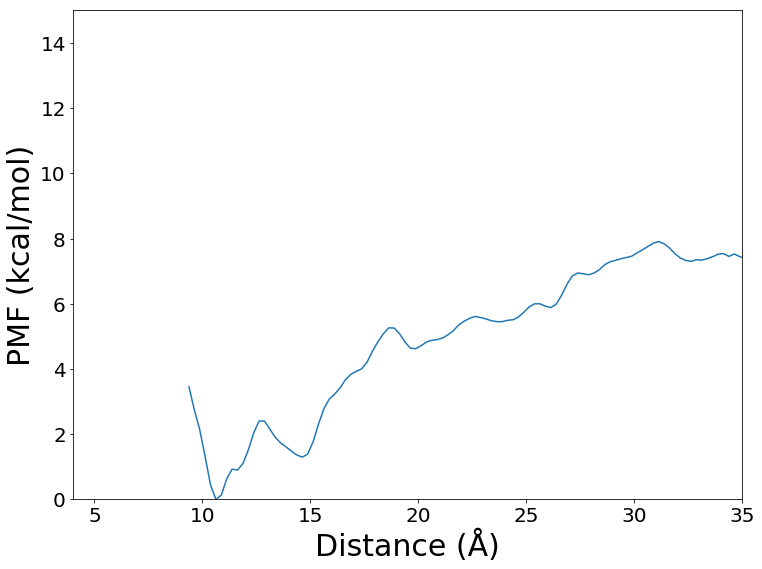

In [23]:
plt.figure(figsize=(12,9))
plt.xlim(4, 35)
plt.ylim(0,15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Distance (Å)', fontsize=30)
plt.ylabel('PMF (kcal/mol)', fontsize=30)
plt.plot(bin_center_i[1:], fe[1:])
plt.show()

In [21]:
f = open('result.dat', 'w')
for i in range(nbins):
    f.write('{:2.2f}    {:2.8f}\n'.format(bin_center_i[i], fe[i]))
f.close()